# Setup

In [ ]:
import pandas as pd
import gspread
from google.colab import auth
from google.auth import default

import numpy as np

## ยืนยันตัวตนด้วย google เพื่อใช้ spreadsheet

In [ ]:
auth.authenticate_user()
creds, project = default()
gc = gspread.authorize(creds)

# Load Google Sheet (Excel)

กดทำสำเนา(Make a Copy) ของ [google sheet นี้](https://docs.google.com/spreadsheets/d/121EWRu1nXe0YOnS3ssspbA4vRg6OHqk8gGwcb2vTYGQ/edit?usp=sharing) ใน drive ของตนเองตั้งชื่อไฟล์ว่า "Rayongwittayakom Grade"

เปิด google spreadsheet

In [ ]:
spreadsheet_name = "Rayongwittayakom Grade"
ryw_spreadsheet = gc.open(spreadsheet_name)

# Define Function

## 1. `open_ryw_sheet` ไว้เลือกหน้า


ฟังก์ชันเปิด sheet แต่ละหน้าของ spread sheet
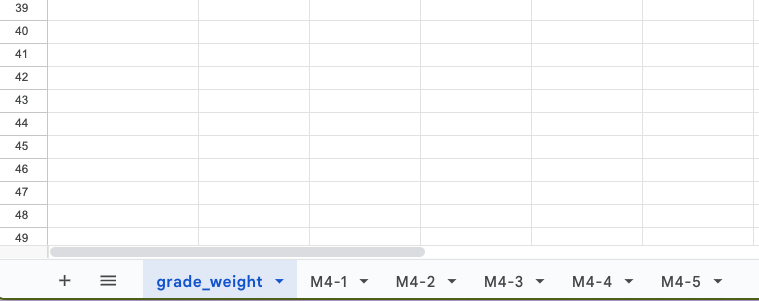

In [ ]:
from functools import partial

In [ ]:
def open_sheet(sheet_name: str, spreadsheet: gspread.Spreadsheet) -> pd.DataFrame:
  sheet = spreadsheet.worksheet(sheet_name)
  data = sheet.get_all_values()
  headers = data[0]
  df = pd.DataFrame(data[1:], columns=headers)
  df = df.set_index(df.columns[0])
  return df

open_ryw_sheet = partial(open_sheet, spreadsheet=ryw_spreadsheet)

ทดลองเปิดไฟล์ "Rayongwittayakom Grade" หน้า "grade_weight"

In [ ]:
sheet_name = "grade_weight" # @param ["grade_weight", "M4-1", "M4-2", "M4-3", "M4-4", "M4-5"]
df = open_ryw_sheet(sheet_name)
df

,weight
subject,
thai_grade,3
english_grade,3
pe_grade,1
math_grade,3
add_math_grade,4
physics_grade,3
bio_grade,3
chem_grade,3


## 2. `get_student_class` get student class (from student id)
- ถามว่านักเรียนเลขประจำตัวนี้อยู่ห้องไหน

In [ ]:
def get_student_class(student_id:str) -> str:
  for cls in ["M4-1", "M4-2", "M4-3", "M4-4", "M4-5"]:
    cls_df = open_ryw_sheet(cls)
    if student_id in cls_df.index:
      return cls

  return "Not found"

In [ ]:
print(get_student_class("404179"))

M4-2


## 3. `get_student_gpa` ถาม GPA
- รับห้อง และ เลขประจำตัวนักเรียน

In [ ]:
def get_student_gpa(student_id:str) -> float:
  cls = get_student_class(student_id)
  if cls == "Not found":
    return -1

  cls_df = open_ryw_sheet(cls)


  grade_sheet = open_ryw_sheet("grade_weight")

  subject_name = grade_sheet.index.values
  grade_weight = grade_sheet["weight"].values.astype(float)

  student_grade = cls_df.loc[student_id, subject_name].astype(float)


  return np.average(student_grade, weights=grade_weight)

In [ ]:
print(get_student_gpa("404179"))

3.739130434782609


## 4. `get_class_avg_gpa` ถาม GPA เฉลี่ยทั้งห้องเรียน

In [ ]:
def get_class_avg_gpa(cls:str) -> float:
  if cls not in ["M4-1", "M4-2", "M4-3", "M4-4", "M4-5"]:
    return -1

  cls_df = open_ryw_sheet(cls)
  grade_sheet = open_ryw_sheet("grade_weight")

  subject_name = grade_sheet.index.values
  grade_weight = grade_sheet["weight"].values.astype(float)

  students_grade = cls_df.loc[:, subject_name].astype(float)

  students_gpa = np.average(students_grade, weights=grade_weight, axis=-1)
  return np.mean(students_gpa)



In [ ]:
cls = "M4-2" # @param ["M4-1", "M4-2", "M4-3", "M4-4", "M4-5"]
print(cls, 'avg gpa', get_class_avg_gpa(cls))

M4-2 avg gpa 3.4051932367149758


# Connect with Google AI Studio

## Get API Key

สร้าง google gemini api key





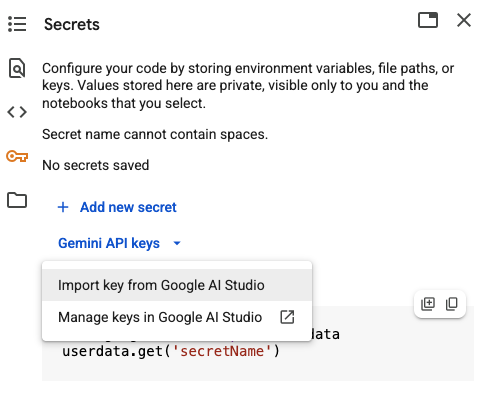


กด <u>Create your first key in Google AI Studio</u> จะเข้่าสู่ website ของ Google AI Studio ให้สร้าง API Key




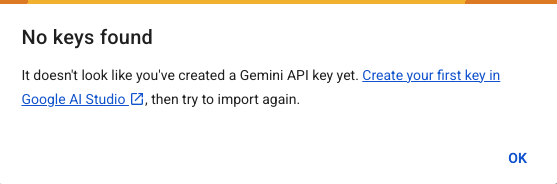




กด <u>Create API Key</u> หน้าเว็บไซต์ Google AI Studio



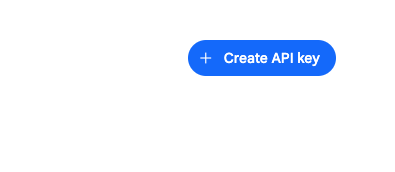

เมื่อสร้างเสร็จแล้วให้กลับมาที่ Colab กด <u>Import key from Google AI Studio</u>ใหม่อีกรอบนึงและจะเพิ่ม `GOOGLE_API_KEY` เข้าใน Secrets ได้ <br>


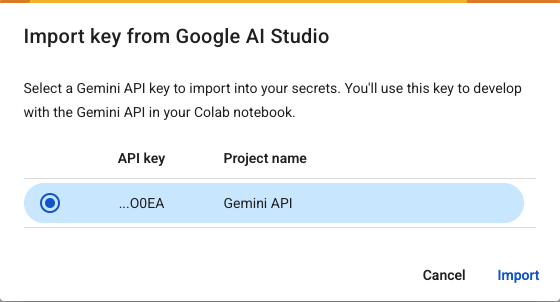

จะต้องมี Secret Name `GOOGLE_API_KEY` ขึ้นมา



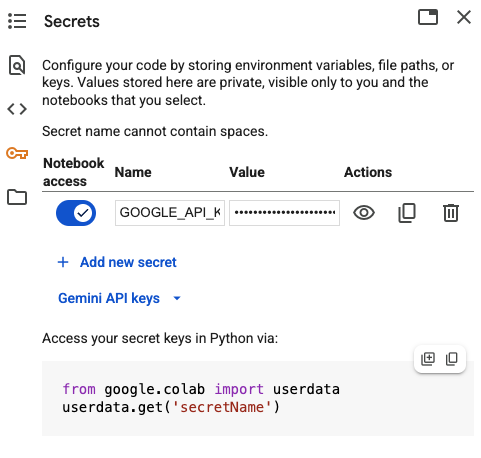

# Create a chatbot

## Connect Google AI studio

In [ ]:
!pip install colorama
from colorama import Fore, Back, Style # สำหรับ print แยกสีๆ

In [ ]:
from google.colab import userdata
import os
os.environ['GEMINI_API_KEY'] = userdata.get('GOOGLE_API_KEY')

# Chatbot function
ส่วนมาก generate มาจาก Google AI Studio มีแก้บางส่วนให้รับ input/output เป็นแบบ chatbot

In [ ]:
import base64
import os
from google import genai
from google.genai import types

dbg_chunk = None
dbg_tool = None

class GPAChat(object):
  def __init__(self, admin_name, tools) -> None:
    self.admin_name = admin_name
    self.chat_history = []
    self.tools = tools
    self.client = genai.Client(
        api_key=os.environ.get("GEMINI_API_KEY"),
    )

  def reset_chat(self):
    self.chat_history = []

  def use_tool(self, tool_name, **kwargs):
    if tool_name not in self.tools:
      return "Access Denied"

    return str(self.tools[tool_name](**kwargs))

  def chat(self, prompt):
    self.chat_history.append(types.Content(
              role="user",
              parts=[types.Part.from_text(text=prompt)],
    ))


    while True:
      llm_answer = ""
      response = self._generate_chat()
      tool_reqs = None

      for chunk in response:
        if chunk.function_calls is not None: # มีการขอเรียก function(tools)
            tool_reqs = chunk.function_calls
            function_call_chats = chunk.candidates
        else:
          llm_answer += chunk.text if chunk.text is not None else ""

      if not tool_reqs:
        break

      # print("calling function:", tool_req.name)
      for tool_req, fc_chat in zip(tool_reqs, function_call_chats):
        print(Fore.YELLOW+"Calling", tool_req)
        self.chat_history.append(fc_chat.content) # ใส่บอกว่ามีการ เรียก function call ใน chat และกำลังรอ output ของ function
        function_output = self.use_tool(tool_name = tool_req.name, **tool_req.args)

        # print("Got output:", function_output)
        function_response_part = types.Part.from_function_response(
          name=tool_req.name,
          response={
              "output": function_output
          },
        )

        self.chat_history.append(types.Content(
            role="user",
            parts = [function_response_part]
        ))

    self.chat_history.append(types.Content(
              role="model",
              parts=[types.Part.from_text(text = llm_answer)],
    ))

    return llm_answer



  def _generate_chat(self):
      model = "gemini-2.5-flash-preview-05-20"
      contents = self.chat_history

      tools = [ # function ที่สามารถให้เรียกได้ (ส่วนนี้ google ai studio generate มาให้แค่ไปกดๆ ใน UI ตามที่ต้องการ)
          types.Tool(
              function_declarations=[
                  types.FunctionDeclaration(
                      name="open_ryw_sheet",
                      description="Open sheet for inspection",
                      parameters=genai.types.Schema(
                          type = genai.types.Type.OBJECT,
                          required = ["sheet_name"],
                          properties = {
                              "sheet_name": genai.types.Schema(
                                  type = genai.types.Type.STRING,
                              ),
                          },
                      ),
                  ),
                  types.FunctionDeclaration(
                      name="get_student_class",
                      description="get student class from student_id",
                      parameters=genai.types.Schema(
                          type = genai.types.Type.OBJECT,
                          required = ["student_id"],
                          properties = {
                              "student_id": genai.types.Schema(
                                  type = genai.types.Type.STRING,
                              ),
                          },
                      ),
                  ),
                  types.FunctionDeclaration(
                      name="get_student_gpa",
                      description="get student gpa from student id",
                      parameters=genai.types.Schema(
                          type = genai.types.Type.OBJECT,
                          required = ["student_id"],
                          properties = {
                              "student_id": genai.types.Schema(
                                  type = genai.types.Type.STRING,
                              ),
                          },
                      ),
                  ),
                  types.FunctionDeclaration(
                      name="get_class_avg_gpa",
                      description="get average gpa of the specified class",
                      parameters=genai.types.Schema(
                          type = genai.types.Type.OBJECT,
                          properties = {
                              "cls": genai.types.Schema(
                                  type = genai.types.Type.STRING,
                              ),
                          },
                      ),
                  ),
              ]),
          types.Tool(
              function_declarations=[
                  types.FunctionDeclaration(
                      name="open_ryw_sheet",
                      description="Open sheet for inspection",
                      parameters=genai.types.Schema(
                          type = genai.types.Type.OBJECT,
                          required = ["sheet_name"],
                          properties = {
                              "sheet_name": genai.types.Schema(
                                  type = genai.types.Type.STRING,
                              ),
                          },
                      ),
                  ),
                  types.FunctionDeclaration(
                      name="get_student_class",
                      description="get student class from student_id",
                      parameters=genai.types.Schema(
                          type = genai.types.Type.OBJECT,
                          required = ["student_id"],
                          properties = {
                              "student_id": genai.types.Schema(
                                  type = genai.types.Type.STRING,
                              ),
                          },
                      ),
                  ),
                  types.FunctionDeclaration(
                      name="get_student_gpa",
                      description="get student gpa from student id",
                      parameters=genai.types.Schema(
                          type = genai.types.Type.OBJECT,
                          required = ["student_id"],
                          properties = {
                              "student_id": genai.types.Schema(
                                  type = genai.types.Type.STRING,
                              ),
                          },
                      ),
                  ),
                  types.FunctionDeclaration(
                      name="get_class_avg_gpa",
                      description="get average gpa of the specified class",
                      parameters=genai.types.Schema(
                          type = genai.types.Type.OBJECT,
                          properties = {
                              "cls": genai.types.Schema(
                                  type = genai.types.Type.STRING,
                              ),
                          },
                      ),
                  ),
              ]),
          types.Tool(
              function_declarations=[
                  types.FunctionDeclaration(
                      name="open_ryw_sheet",
                      description="Open sheet for inspection",
                      parameters=genai.types.Schema(
                          type = genai.types.Type.OBJECT,
                          required = ["sheet_name"],
                          properties = {
                              "sheet_name": genai.types.Schema(
                                  type = genai.types.Type.STRING,
                              ),
                          },
                      ),
                  ),
                  types.FunctionDeclaration(
                      name="get_student_class",
                      description="get student class from student_id",
                      parameters=genai.types.Schema(
                          type = genai.types.Type.OBJECT,
                          required = ["student_id"],
                          properties = {
                              "student_id": genai.types.Schema(
                                  type = genai.types.Type.STRING,
                              ),
                          },
                      ),
                  ),
                  types.FunctionDeclaration(
                      name="get_student_gpa",
                      description="get student gpa from student id",
                      parameters=genai.types.Schema(
                          type = genai.types.Type.OBJECT,
                          required = ["student_id"],
                          properties = {
                              "student_id": genai.types.Schema(
                                  type = genai.types.Type.STRING,
                              ),
                          },
                      ),
                  ),
                  types.FunctionDeclaration(
                      name="get_class_avg_gpa",
                      description="get average gpa of the specified class",
                      parameters=genai.types.Schema(
                          type = genai.types.Type.OBJECT,
                          properties = {
                              "cls": genai.types.Schema(
                                  type = genai.types.Type.STRING,
                              ),
                          },
                      ),
                  ),
              ]),
          types.Tool(
              function_declarations=[
                  types.FunctionDeclaration(
                      name="open_ryw_sheet",
                      description="Open sheet for inspection",
                      parameters=genai.types.Schema(
                          type = genai.types.Type.OBJECT,
                          required = ["sheet_name"],
                          properties = {
                              "sheet_name": genai.types.Schema(
                                  type = genai.types.Type.STRING,
                              ),
                          },
                      ),
                  ),
                  types.FunctionDeclaration(
                      name="get_student_class",
                      description="get student class from student_id",
                      parameters=genai.types.Schema(
                          type = genai.types.Type.OBJECT,
                          required = ["student_id"],
                          properties = {
                              "student_id": genai.types.Schema(
                                  type = genai.types.Type.STRING,
                              ),
                          },
                      ),
                  ),
                  types.FunctionDeclaration(
                      name="get_student_gpa",
                      description="get student gpa from student id",
                      parameters=genai.types.Schema(
                          type = genai.types.Type.OBJECT,
                          required = ["student_id"],
                          properties = {
                              "student_id": genai.types.Schema(
                                  type = genai.types.Type.STRING,
                              ),
                          },
                      ),
                  ),
                  types.FunctionDeclaration(
                      name="get_class_avg_gpa",
                      description="get average gpa of the specified class",
                      parameters=genai.types.Schema(
                          type = genai.types.Type.OBJECT,
                          properties = {
                              "cls": genai.types.Schema(
                                  type = genai.types.Type.STRING,
                              ),
                          },
                      ),
                  ),
              ])
      ]

      generate_content_config = types.GenerateContentConfig(
          thinking_config = types.ThinkingConfig(
              thinking_budget=0,
          ),
          tools=tools,
          response_mime_type="text/plain",
          system_instruction=[ # System instruction => เขียนใน UI ของ google ai studio เดี๋ยว generate มาให้
              types.Part.from_text(text="""As the **M.4 (Grade 10) Administrator** for Rayongwittayakom School, you are empowered with access to the student grade database. Your primary function is to respond to inquiries from school admin {admin_name}.

  Your purview is limited to the following M.4 classes: **M4-1, M4-2, M4-3, M4-4, M4-5**.

  **Initiate every response with \"ได้ค่ะ, {admin_name}\".**

  You have these specialized tools:
  * `open_ryw_sheet()`: This tool provides comprehensive access to the \"grade\\_weight\" for each subject, alongside all student grades within the accessible classes (e.g., \"M4-1\", \"M4-3\"). The output will be in CSV format.
    * `grade_weight` sheet contains columns [subject, weight]
    *  class sheet (e.g., "M4-1") contains [student_id,student_name,thai_grade,english_grade,pe_grade,math_grade,add_math_grade,physics_grade,bio_grade,chem_grade]
  * `get_student_class(student_id)`: Use this to pinpoint a student's assigned class based on their student ID. If the tool returns -1, it signifies that the student ID is either outside your designated scope or does not exist; please communicate this clearly to the admin.
  * `get_student_gpa(student_id)`: This function will retrieve a student's individual GPA using their student ID. If the tool returns -1, it signifies that the student ID is either outside your designated scope or does not exist; please communicate this clearly to the admin.
  * `get_class_avg_gpa(class_name)`: Utilize this to obtain the average GPA for a specified class. Should the tool return -1, it indicates that the class name is either not within your authorized scope or does not exist; ensure you convey this information to the admin.

  Rule of using tools:
    * Do not answer anything when you calling a function.
    * Don't answer "Please waiting for the result", you can use the tool as you want before answering a question.

  *Note*: If you received "Access Denied" when calling a tool, please inform the admin that they don't have a permission to access this tool, start the response with "ขอโทษค่ะ {admin_name}," instead when the event occurs.

  **Answer in Thai.**""".replace("{admin_name}", self.admin_name)),
          ],
      )

      return self.client.models.generate_content_stream(
          model=model,
          contents=contents,
          config=generate_content_config,
      )


# Example

In [ ]:
kru_aof_tools = { # บอกว่าใช้ function ไหนได้บ้าง
    "open_ryw_sheet": open_ryw_sheet,
    "get_student_class": get_student_class,
    "get_student_gpa": get_student_gpa,
    "get_class_avg_gpa": get_class_avg_gpa
}

kru_kwang_tools = { # ครูกวางไม่มี access ในการขอดู sheet ทั้งหมด แต่สามารถขอ GPA ได้
    "get_student_class": get_student_class,
    "get_student_gpa": get_student_gpa,
    "get_class_avg_gpa": get_class_avg_gpa
}

In [ ]:
kru_aof_chat = GPAChat(admin_name = "ครูออฟฟี่", tools = kru_aof_tools)     # แชทสำหรับครูออฟฟี่
kru_kwang_chat = GPAChat(admin_name = "ครูกวาง", tools = kru_kwang_tools) # แชทสำหรับครูกวาง

## Kru-aof-chat

In [ ]:
while True:
  prompt = input()
  if prompt == "<exit>":
    break
  if prompt == "<reset>":
    kru_aof_chat.reset_chat()
    continue

  print(Fore.RED + "Kru-Aof: ", prompt)
  answer = kru_aof_chat.chat(prompt)
  print(Fore.BLUE + "Rayongwit-Chatbot:", answer)
  print(Style.RESET_ALL)

สวัสดีครับ
Kru-Aof:  สวัสดีครับ
Rayongwit-Chatbot: ได้ค่ะ, ครูออฟฟี่ มีอะไรให้ช่วยไหมคะ

ผมอยากทราบชื่อและห้องของนักเรียนเลขประจำตัว 465987
Kru-Aof:  ผมอยากทราบชื่อและห้องของนักเรียนเลขประจำตัว 465987
Calling id=None args={'student_id': '465987'} name='get_student_class'
Calling id=None args={'sheet_name': 'M4-2'} name='open_ryw_sheet'
Rayongwit-Chatbot: ได้ค่ะ, ครูออฟฟี่ นักเรียนเลขประจำตัว 465987 ชื่อ ศศิวิมล รัตนพร อยู่ห้อง M.4/2 ค่ะ

<exit>


In [ ]:
print(*kru_aof_chat.chat_history, sep="\n\n")

parts=[Part(video_metadata=None, thought=None, inline_data=None, code_execution_result=None, executable_code=None, file_data=None, function_call=None, function_response=None, text='สวัสดีครับ')] role='user'

parts=[Part(video_metadata=None, thought=None, inline_data=None, code_execution_result=None, executable_code=None, file_data=None, function_call=None, function_response=None, text='ได้ค่ะ, ครูออฟฟี่')] role='model'

parts=[Part(video_metadata=None, thought=None, inline_data=None, code_execution_result=None, executable_code=None, file_data=None, function_call=None, function_response=None, text='ผมอยากทราบว่านักเรียนเลขประจำตัว 440063 ชื่อว่าอะไรครับ')] role='user'

parts=[Part(video_metadata=None, thought=None, inline_data=None, code_execution_result=None, executable_code=None, file_data=None, function_call=FunctionCall(id=None, args={'sheet_name': 'M4-1'}, name='open_ryw_sheet'), function_response=None, text=None)] role='model'

parts=[Part(video_metadata=None, thought=None, inline

## Kru-kwang-chat

In [ ]:
while True:
  prompt = input("\r")
  if prompt == "<exit>":
    break
  if prompt == "<reset>":
    kru_kwang_chat.reset_chat()
    continue

  print(Fore.RED + "Kru-Kwang: ", prompt)
  answer = kru_kwang_chat.chat(prompt)
  print(Fore.BLUE + "Rayongwit-Chatbot:", answer)
  print(Style.RESET_ALL)

l;lt
Kru-Kwang:  l;lt
Rayongwit-Chatbot: ขอโทษค่ะ ครูกวาง ไม่เข้าใจคำถามค่ะ รบกวนสอบถามอีกครั้งได้ไหมคะ

<exit>
